# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# создадим датафрейм и генератор изображений, загрузим изображения
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1/255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Изучим полученный датафрейм.

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Так, наш датафрейм содержит 7591 объект и 2 признака: название файла изображения и возраст человека на изображении. Типы данных: название - строка, возраст - целое число. Пропуски отсутствуют.

Изучим распределение возрастов в наборе данных.

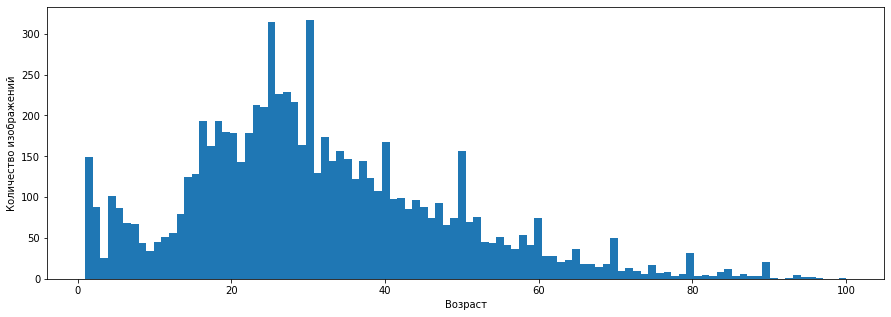

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(labels['real_age'], bins=100)
ax = plt.gca()
ax.set_xlabel("Возраст")
ax.set_ylabel("Количество изображений")
plt.show()

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Посмотрим на топ-10 наиболее представленных в датасете возрастов.

In [8]:
labels.groupby('real_age').count().reset_index().sort_values(by='file_name', ascending=False).head(10)

,real_age,file_name
29,30,317
24,25,315
26,27,229
25,26,226
27,28,217
22,23,213
23,24,211
15,16,193
17,18,193
18,19,180


Больше всего изображений соответствуют возрастам 30 и 25 лет. Также заметен 10-летний шаг по всплеску количества соответствующих фотографий: 40, 50, 60, 70, 80, 90.

Средний возраст по выборке равен 31 году, медианное значение - 29 лет.

Выведем на экран и изучим 12 случайных фотографий из нашего датасета (над каждой фотографией выведем соответствующий ей возраст).

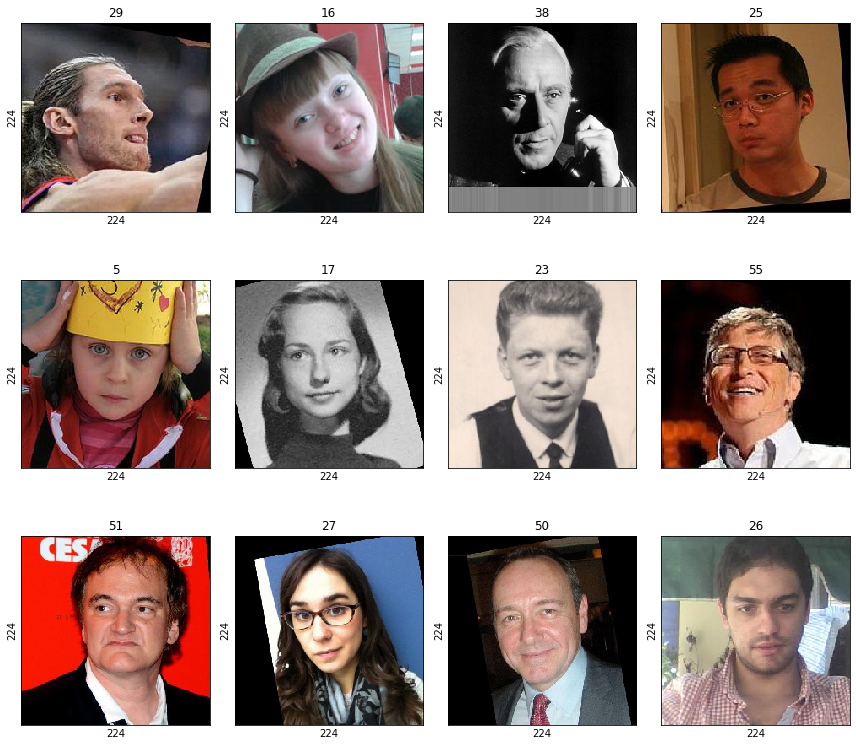

In [38]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(str(target[i]))
    plt.xlabel(features[i].shape[0])
    plt.ylabel(features[i].shape[1])

Убедились, что фотографии приведены к одному размеру. Также видно, что одни фото имеют скошенные рамки, другие - нет. Фотографии сделаны при разных условиях освещенности и на разные фотоаппараты (имеют разную степень зернистости и контраста). При обучении модели сразу добавим аугментацию отражения по горизонтали (это сохранит ключевые признаки и вдвое увеличит количество изображений, на которых будет обучаться модель).
Если показатель MAE будет недостаточно высоким,  рассмотрим добавление шума к изображениям и небольшого сдвига. Ориентация лиц соответствует "реальному" положению (условная вертикальная ось перпендикулярна земле, глаза сверху, ноги снизу). Следовательно, применять повороты изображений не будем.

## Обучение модели

`(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)`

Для предсказаний возраста людей по фото будем обучать модель **ResNet50**. В качестве оптимизатора используем **Adam** с шагом обучения 0.0001. В качестве "костяка" модели воспользуемся предобучением на **ImageNet**, верхушку добавим вручную с последним полносвязным слоем с 1 нейроном и активацией методом **ReLu**. Обучим модель за 15 эпох.


В загрузчиках `load_train` и `load_test` выполним разбиение датасета на обучающий и тестовой (3 : 1). В обучающем наборе добавим аугментацию *horizontal_flip*. Приведем данные к диапазону от 0 до 1, размер изображений установим 224 х 224 пикселя.

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,  horizontal_flip=True, rescale=1/255)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + '/labels.csv'),
                                                       directory=path + '/final_files', x_col='file_name',  
                                                       y_col='real_age', target_size=(224, 224), batch_size=32,
                                                       class_mode='raw', seed=12345, subset='training') 
    return train_datagen_flow

 
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + '/labels.csv'),
                                                       directory=path + '/final_files', x_col='file_name',  
                                                       y_col='real_age', target_size=(224, 224), batch_size=32,
                                                       class_mode='raw', seed=12345, subset='validation') 
    return test_datagen_flow
 
 
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data = test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

Посмотрим на логи выполнения кода в специальном GPU-тренажере.

```
Train for 178 steps, validate for 60 steps

Epoch 1/15

178/178 - 53s - loss: 269.0489 - mae: 11.7089 - val_loss: 823.3470 - val_mae: 23.7990

Epoch 2/15

178/178 - 44s - loss: 78.4311 - mae: 6.6298 - val_loss: 782.5700 - val_mae: 23.0396

Epoch 3/15

178/178 - 43s - loss: 49.6112 - mae: 5.3433 - val_loss: 609.8105 - val_mae: 19.6189

Epoch 4/15

178/178 - 43s - loss: 35.3802 - mae: 4.5469 - val_loss: 107.5008 - val_mae: 7.8348

Epoch 5/15

178/178 - 43s - loss: 26.8560 - mae: 3.9553 - val_loss: 87.1009 - val_mae: 7.0701

Epoch 6/15

178/178 - 43s - loss: 23.1030 - mae: 3.6669 - val_loss: 80.3116 - val_mae: 6.8414

Epoch 7/15

178/178 - 44s - loss: 18.7604 - mae: 3.3234 - val_loss: 64.0030 - val_mae: 6.0009

Epoch 8/15

178/178 - 43s - loss: 14.7996 - mae: 2.9827 - val_loss: 63.5495 - val_mae: 5.9949

Epoch 9/15

178/178 - 44s - loss: 12.6178 - mae: 2.7462 - val_loss: 63.9914 - val_mae: 6.0136

Epoch 10/15

178/178 - 43s - loss: 11.8458 - mae: 2.6126 - val_loss: 66.8120 - val_mae: 6.1141

Epoch 11/15

178/178 - 43s - loss: 10.1023 - mae: 2.3854 - val_loss: 63.5355 - val_mae: 6.0683

Epoch 12/15

178/178 - 43s - loss: 8.4466 - mae: 2.2345 - val_loss: 65.5261 - val_mae: 6.0264

Epoch 13/15

178/178 - 44s - loss: 8.0377 - mae: 2.1360 - val_loss: 60.4334 - val_mae: 5.7227

Epoch 14/15

178/178 - 43s - loss: 7.3325 - mae: 2.0427 - val_loss: 61.5120 - val_mae: 5.8232

Epoch 15/15

178/178 - 44s - loss: 7.1773 - mae: 2.0388 - val_loss: 63.5877 - val_mae: 6.0415

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 11s - loss: 63.5877 - mae: 6.0415

Test MAE: 6.0415

```

Можем наблюдать несколько отличную друг от друга *интенсивность* снижения метрики MAE на тестовых и валидационнах данных. На 2 эпохе MAE меньше почти в 2 раза, уменьшение MAE_val незначительно. На 4 эпохе происходит снижение MAE_val более чем в 2 раза по сравнению с 3 эпохой.

Итоговый MAE на валидационных данных равен 6.04, что удовлетворяет условию задачи. Однако есть основания утверждать, что при большем количестве эпох можно добиться еще большей точности в предсказаниях.

## Анализ обученной модели

Наша модель в среднем ошибается на 6 лет. Такого показателя достаточно, чтобы предлагать покупателям магазина товары, потенциально интересные для их возрастной группы. Велика вероятность, что интересы и потребности человека в 32 не будут сильно отличаться от 26-летнего. То же касается 60-ти и 66-летних. (Хотя нельзя не отметить, что есть определенные возрастные рубежи, которые по физиологическим или социальным причинам могут вызвать значительные изменения в покупательстком поведении: выход на пенсию, возрастные заболевания, и т.д.

С другой стороны, со второй поставленной задачей данная модель не в состоянии справиться самостоятельно. Она годится как дополнительный элемент контроля, но для выявления продаж табака и алкоголя несовершеннолетним недостаточно точна. Потенциально, она может пропустить продажу запрещенных для несовершеннолетних продуктов 12/13-летнему подростку. Таким образом, для выполнения данной функции использование модели представляется нецелесообразным. 

В заключение можно сказать, что исследовать грани качества модели может помочь ее тестирование на заранее отобранных возрастных группах. К примеру, при тестировании модели на возрастах от 12 до 21 модель может (теоретически) показать гораздо более высокую точность, чем по всей совокупности возрастов (в период взросления люди меняются выразительнее и заметнее, с течением времени определить возраст все сложнее).